# Project
Spotify has a discover weekly playlist, but a daily playlist built on liked songs would be more useful to someone like myself who listens to the discover weekly playlist daily

Ideas for song discovery
- favor less popular songs
- favor songs saved within the past 30 songs
- use the spotify recomendation sytem to determine new artists and songs

In [514]:
x = os.getenv('SPOTIPY_CLIENT_ID')
print(x)

80d546f8fec24b6c9d5f957f194dd8fd


In [370]:
from __future__ import print_function    # (at top of module)
from spotipy.oauth2 import SpotifyClientCredentials
import json
import spotipy
import time
import sys
import os
from pprint import pprint
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SPOTIPY_CLIENT_ID = os.getenv('SPOTIPY_CLIENT_ID')
SPOTIPY_CLIENT_SECRET = os.getenv('SPOTIPY_CLIENT_SECRET')
SPOTIPY_REDIRECT_URI = os.getenv('SPOTIPY_REDIRECT_URI')

client_credentials_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
sp.trace = False

## Step 1: Get song URI's from "liked songs" playlist

In [257]:
playlist = 'spotify:playlist:5R7g1zHpXcFagycWipXqMf'    # playlist id

def get_playlist_songs(playlist_id):
    
    offset = 0                                              # track position in playlist
    
    # create list of song names
    songs = []                                              # create list of songs to append to 

    # loop through tracklist and save songs to list
    while True:
        response = sp.playlist_items(playlist_id,
                                    offset=offset,
                                    fields='items.track.id,total',
                                    additional_types=['track'])
        
        if len(response['items']) == 0:
            break

        offset = offset + len(response['items'])

        songs.append(response['items'])

    # create list to store song ids
    song_ids = []

    for song in songs:
        for x in song:
            song_ids.append('spotify:track:' + x['track']['id'])

    return song_ids

song_ids = get_playlist_songs(playlist)
song_ids[1:5]

['spotify:track:21HFXMiwe4lyaLE7SAIW8i',
 'spotify:track:2S4ndewv3O9QvkX2eTGmnv',
 'spotify:track:1KFwTRMXUKNr0IriheeVJn',
 'spotify:track:19Ov4l8mtvCT1iEUKks4aM']

## Step 2: Get Song Analysis Info From Each Song and Save in List

In [307]:
def get_playlist_data(song_ids):

    # create DataFrame
    cols = ['song', 'song_id', 'artist', 'artist_id', 'followers', 'genres', 'popularity', 'release_date', 'danceability', 'energy', 'key', 'loudness', 'speech', 'acoustic', 'instrumental', 'liveness', 'valence', 'tempo', 'duration', 'time_signature']
    playlist_data = pd.DataFrame(columns=cols)

    # get data from song analysis and store in DataFrame
    for tids in song_ids:

        # artist
        artist = sp.track(tids)['artists'][0]['name']
        artist_id = sp.track(tids)['artists'][0]['uri']

        # song 
        song = sp.track(tids)['name']
        song_id = sp.track(tids)['uri']
        release_date = sp.track(tids)['album']['release_date']

        # artist info
        artist_data = sp.artist(artist_id)
        followers = artist_data['followers']['total']
        genres = artist_data['genres']
        popularity = artist_data['popularity']

        # song features from analysis
        features = sp.audio_features(tids)
        dance = features[0]['danceability']
        energy = features[0]['energy']
        # key_dict = {1:'C', 2:'Db', 3:'D', 4:'Eb', 5:'E', 6:'F', 7:'F#', 8:'G', 9:'Ab', 10:'A', 11:'Bb', 12:'B'}
        # key = key_dict[features[0]['key']]
        key = features[0]['key']
        loudness = features[0]['loudness']
        speech = features[0]['speechiness']
        acoustic = features[0]['acousticness']
        instrumental = features[0]['instrumentalness']
        liveness = features[0]['liveness']
        valence = features[0]['valence']
        tempo = features[0]['tempo']
        duration = features[0]['duration_ms']
        ts = features[0]['time_signature']


        data = [song, song_id, artist, artist_id, followers, genres, popularity, release_date, dance, energy, key, loudness, speech, acoustic, instrumental, liveness, valence, tempo, duration, ts]

        playlist_data.loc[len(playlist_data)] = data

    return playlist_data

df = get_playlist_data(song_ids=song_ids)

## Given song or artist, produce pandas dataframe of recommended artists and top 10 songs

In [252]:
def get_recommended(uri):

     if uri.split(':')[1] == 'track':
          # get song features
          feat = sp.track(uri)
          # get artist id
          art_id = feat['artists'][0]['uri']
          # get artist informaiton from artist id
          art = sp.artist(art_id)
          # get artist uri
          art_id = feat['artists'][0]['id']

     else:
          art_id = uri
     
     # get recommended artists
     rec = sp.recommendations(seed_artists=[art_id])

     # single out a recomended artist for example
     recomended_artists = rec['tracks']
     # get single artist uri
     artist_uri = recomended_artists[2]

     cols = ['artist', 'artist_id', 'song', 'song_id']
     recomended = pd.DataFrame(columns=cols)
     for recomended_artist in recomended_artists:
          artist = recomended_artist['artists'][0]['name']
          artist_uri = recomended_artist['artists'][0]['uri']
          song = recomended_artist['name']
          song_uri = recomended_artist['uri']

          data = [artist, artist_uri, song, song_uri]
          recomended.loc[len(recomended)] = data

     return recomended

get_recommended(song_ids[9]).head()



,artist,artist_id,song,song_id
0,Viktor Vaughn,spotify:artist:0wIb0PhwT3disoWykRhq6V,Lickupon,spotify:track:1wQixSSWydeLgkebOzu3yt
1,MF Grimm,spotify:artist:20W9F94ZPbzoMqxuekMgKi,American Hunger (The Last Supper),spotify:track:6T2zXg2y1YL90IQSbluNFp
2,Count Bass D,spotify:artist:3P1ULKxhVEpywj0hogWT44,How We Met (Feat. Edan),spotify:track:1cBqfgbxWZYLhccf9rSDQY
3,Damu The Fudgemunk,spotify:artist:7Mws36yO3takBR2WMsXOkM,They Who Flock,spotify:track:0YsSp6pd4xxtFFCfIKHCql
4,King Geedorah,spotify:artist:77AKJs9SJqxHXbPgtJPKRa,Krazy World,spotify:track:6wqt7M2wbw2XWAtCqqAfmA


In [510]:
recommended_songs = pd.DataFrame(columns = ['artist', 'artist_id', 'song', 'song_id'])


for song in song_ids:
    pd.concat(recommended_songs, get_recommended(song))

recommended_songs



C:\Users\Mitchell\AppData\Local\Temp/ipykernel_30468/2480292610.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  pd.concat(recommended_songs, get_recommended(song))


TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

## Step 3: Exploratory Data Analysis

In [308]:
df.head()

,song,song_id,artist,artist_id,followers,genres,popularity,release_date,danceability,energy,key,loudness,speech,acoustic,instrumental,liveness,valence,tempo,duration,time_signature
0,Five Stars General,spotify:track:7bwWFIns0l9qXOTDACl4tj,Alexandre Desplat,spotify:artist:71jzN72g8qWMCMkWC5p1Z0,281147,"[french soundtrack, orchestral soundtrack, sou...",61,2017-12-01,0.1290,0.0973,8,-18.790,0.0414,0.8690,0.8080,0.0968,0.035,78.328,91587,4
1,Alright,spotify:track:21HFXMiwe4lyaLE7SAIW8i,Guided By Voices,spotify:artist:4oV5EVJ0XFWsJKoOvdRPvl,137108,"[alternative pop, alternative rock, anti-folk,...",46,1995-04-04,0.0815,0.8620,4,-6.279,0.0541,0.3380,0.8430,0.3200,0.562,207.334,178027,4
2,Like Slow Disappearing,spotify:track:2S4ndewv3O9QvkX2eTGmnv,Turnover,spotify:artist:0gLjJuczGWhqKVMmVpIT52,256088,"[alternative emo, anthem emo, dreamo, emo]",54,2015-09-04,0.5970,0.6900,5,-7.828,0.0302,0.0692,0.0101,0.1330,0.519,123.977,235935,4
3,I Think it is Beautiful that You are 256 Color...,spotify:track:1KFwTRMXUKNr0IriheeVJn,Black Moth Super Rainbow,spotify:artist:4UHzJP2iKVf0RhKIv7ZE2l,96389,"[chillwave, experimental pop, neo-psychedelic]",39,2004-06-08,0.3880,0.8030,8,-9.459,0.2630,0.6130,0.9410,0.3240,0.154,134.520,186307,5
4,Two-Headed Boy,spotify:track:19Ov4l8mtvCT1iEUKks4aM,Neutral Milk Hotel,spotify:artist:2ooIqOf4X2uz4mMptXCtie,580497,"[alternative rock, anti-folk, chamber pop, ele...",54,1998-02-20,0.3420,0.6130,7,-4.084,0.0311,0.7050,0.0000,0.1400,0.267,145.840,266107,4


## Missing Data

In [313]:
df.isna().sum()


song              0
song_id           0
artist            0
artist_id         0
followers         0
genres            0
popularity        0
release_date      0
danceability      0
energy            0
key               0
loudness          0
speech            0
acoustic          0
instrumental      0
liveness          0
valence           0
tempo             0
duration          0
time_signature    0
dtype: int64

## Is any of the Data correlated?

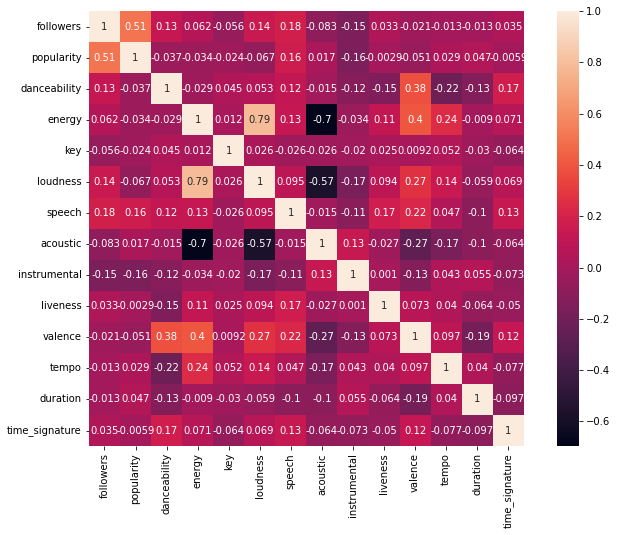

In [371]:
# pick out only numeric data
feature_data = df.drop(columns=['song', 'song_id', 'artist', 'artist_id', 'genres', 'release_date'])


plt.subplots(figsize=(12, 8))
cols = feature_data.columns
feature_data[cols] = feature_data[cols].apply(pd.to_numeric)
feature_data.dtypes
sns.heatmap(feature_data.corr(), annot=True, square=True)
plt.show()

## Create KNN to recommend songs with the closest distance to desired features

In [472]:
from sklearn.neighbors import NearestNeighbors

def knn_classifier(df, genre, features_to_test):
    
    genre_df = df[df['genres'].apply(lambda x: genre in x)]

    knn = NearestNeighbors(n_neighbors=20)
    knn.fit(genre_df[features_to_test])

    n_neighbors = knn.kneighbors(df[features_to_test],       
                  n_neighbors=len(genre_df), return_distance=False)[0]
    
    return genre_df.iloc[n_neighbors,]

features = ['followers', 'popularity', 'danceability', 'energy', 'loudness', 'speech', 'acoustic', 'instrumental', 'liveness', 'valence', 'tempo']
features = ['acoustic', 'danceability', 'energy']
genre = 'pop'

df1 = knn_classifier(df, genre = genre, features_to_test=features)

result_df = df1.drop_duplicates(subset=['artist'], keep='first')



# find the genre word in any of the list elements of the column
result_df

,song,song_id,artist,artist_id,followers,genres,popularity,release_date,danceability,energy,key,loudness,speech,acoustic,instrumental,liveness,valence,tempo,duration,time_signature
145,Good Guy,spotify:track:2JUqYobT8NvARdPmc4ES2x,Frank Ocean,spotify:artist:2h93pZq0e7k5yf4dywlkpM,9504349,"[alternative r&b, hip hop, lgbtq+ hip hop, neo...",81,2016-08-20,0.513,0.1310,0,-12.787,0.4670,0.983,0.004140,0.120,0.814,105.808,66786,5
76,Bubble Gum,spotify:track:3zksbXteOCeSusJ5Xltr3t,Clairo,spotify:artist:3l0CmX0FuQjFxr8SK7Vqag,3296546,"[bedroom pop, indie pop, pop]",75,2019-02-22,0.509,0.0167,9,-24.639,0.1150,0.979,0.000027,0.387,0.229,207.970,175961,3
414,Sunflower,spotify:track:4EpZ4eYuZOwPSSwyqpdHnJ,Rex Orange County,spotify:artist:7pbDxGE6nQSZVfiFdq9lOL,4047497,"[bedroom pop, pop]",77,2017-03-22,0.384,0.7650,6,-4.463,0.0579,0.646,0.003520,0.522,0.567,129.903,252231,4
215,Unbothered,spotify:track:4p1Er46wDz4zGQI7Sxor3W,Omar Apollo,spotify:artist:5FxD8fkQZ6KcsSYupDVoSO,503506,"[alternative r&b, bedroom pop, bedroom soul, i...",66,2018-01-06,0.641,0.4870,2,-7.098,0.0300,0.271,0.002230,0.133,0.322,108.933,124954,4
220,Watermelon Sugar,spotify:track:6UelLqGlWMcVH1E5c4H7lY,Harry Styles,spotify:artist:6KImCVD70vtIoJWnq6nGn3,21184658,[pop],94,2019-12-13,0.548,0.8160,0,-4.209,0.0465,0.122,0.000000,0.335,0.557,95.390,174000,4


In [503]:
# look at the distibution of each key variable in one plot

sns.boxplot(y = sum(pd.to_numeric(result_df['key'])), x = result_df['duration'])

AttributeError: 'bool' object has no attribute 'all'

## Step 4: Scale To User Library

In [467]:
df

,song,song_id,artist,artist_id,followers,genres,popularity,release_date,danceability,energy,key,loudness,speech,acoustic,instrumental,liveness,valence,tempo,duration,time_signature
0,Five Stars General,spotify:track:7bwWFIns0l9qXOTDACl4tj,Alexandre Desplat,spotify:artist:71jzN72g8qWMCMkWC5p1Z0,281147,"[french soundtrack, orchestral soundtrack, sou...",61,2017-12-01,0.1290,0.0973,8,-18.790,0.0414,0.86900,0.808000,0.0968,0.035,78.328,91587,4
1,Alright,spotify:track:21HFXMiwe4lyaLE7SAIW8i,Guided By Voices,spotify:artist:4oV5EVJ0XFWsJKoOvdRPvl,137108,"[alternative pop, alternative rock, anti-folk,...",46,1995-04-04,0.0815,0.8620,4,-6.279,0.0541,0.33800,0.843000,0.3200,0.562,207.334,178027,4
2,Like Slow Disappearing,spotify:track:2S4ndewv3O9QvkX2eTGmnv,Turnover,spotify:artist:0gLjJuczGWhqKVMmVpIT52,256088,"[alternative emo, anthem emo, dreamo, emo]",54,2015-09-04,0.5970,0.6900,5,-7.828,0.0302,0.06920,0.010100,0.1330,0.519,123.977,235935,4
3,I Think it is Beautiful that You are 256 Color...,spotify:track:1KFwTRMXUKNr0IriheeVJn,Black Moth Super Rainbow,spotify:artist:4UHzJP2iKVf0RhKIv7ZE2l,96389,"[chillwave, experimental pop, neo-psychedelic]",39,2004-06-08,0.3880,0.8030,8,-9.459,0.2630,0.61300,0.941000,0.3240,0.154,134.520,186307,5
4,Two-Headed Boy,spotify:track:19Ov4l8mtvCT1iEUKks4aM,Neutral Milk Hotel,spotify:artist:2ooIqOf4X2uz4mMptXCtie,580497,"[alternative rock, anti-folk, chamber pop, ele...",54,1998-02-20,0.3420,0.6130,7,-4.084,0.0311,0.70500,0.000000,0.1400,0.267,145.840,266107,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,Dræm Girl,spotify:track:6lbLn5iL2NBJnbib7bTXMn,No Vacation,spotify:artist:32zeX1IoVKAGWMyy1isKUq,341206,"[indie garage rock, indie pop, indie surf]",56,2015-07-15,0.1920,0.9520,2,-5.888,0.2580,0.00164,0.716000,0.3070,0.262,172.752,234607,4
419,Please Be Mine,spotify:track:7DYaEBQbj6FQCsgPr0uc6p,Molly Burch,spotify:artist:6bEYoIUTLdcs4lZBNVw5L5,71381,[],42,2017-02-17,0.3400,0.4230,9,-7.141,0.0292,0.19200,0.000106,0.1010,0.140,122.563,303627,3
420,Cool,spotify:track:1yLQ64ZTgJFkMhHE49NcgP,Zack Villere,spotify:artist:5jLbQGcvxehi2Z6qkUP9Rh,109804,[bedroom pop],38,2017-05-23,0.7330,0.6790,7,-6.162,0.2070,0.29600,0.000000,0.6050,0.882,93.972,125236,4
421,Everytime,spotify:track:4zvHZWOGyL7WcmqHOgtGCW,boy pablo,spotify:artist:7wbkl3zgDZEoZer357mVIw,996587,"[bedroom pop, bergen indie, indie pop, norwegi...",66,2017-05-19,0.4310,0.6630,2,-10.066,0.0351,0.02490,0.039700,0.1170,0.855,203.908,172941,4


## Step 5: Create Interactive Web App so Anyone Can Use Code

## Print Song Analysis

categorial based on key

IDEAs 
- Generate New Discover Weekly Playlist Based on Recomendations Of Each Artist
- Show user top ten tracks over what duration
- use recommended artists to generate new playlists
- is fade in/fade out used in a specific time period or genre
- actively recommend and queue songs based on length of time listened to a song
- predict genre with audio signal
- predict chords with auidio analysis
- create playlists based on what friends are listening to 
- on this day last year, you listened to this song